## Data Mining Techniques
### COVID-19 data
Kimberley Boersma (2572145), Neil Mizzi (2674737), Selma Muhammad (2578081)

In [43]:
# Imports
import os
import pandas as pd
import csv
import kaggle

# other imports
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, mean_absolute_error, classification_report
from sklearn.utils.testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning
from copy import copy
import seaborn as sns
from scipy.stats import norm
import matplotlib.dates as mdates
# import matplotlib.colors as mcolors
# import random
# import math
# import time
# from sklearn.linear_model import LinearRegression, BayesianRidge
# from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeRegressor
# from sklearn.svm import SVR
from datetime import date, datetime
from dateutil.parser import parse
# import us
# import operator 
# plt.style.use('fivethirtyeight')
%matplotlib inline 

d:\dropbox\projects\results\venv\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)


# Covid Tracking Dataset (w/ hospitalised data)

Source: https://covidtracking.com/

## Step 1: Load and Clean the Data

In [44]:
all_cases = pd.read_csv('https://covidtracking.com/api/v1/states/daily.csv')

# Delete unecessary rows
for row in ['negative', 'pending', 'hash', 'negativeIncrease', 'totalTestResults', 'totalTestResultsIncrease', 'dateChecked', 'fips', 'inIcuCumulative', 'onVentilatorCumulative', 'total', 'posNeg', 'deathIncrease', 'hospitalizedIncrease', 'positiveIncrease']:
    del all_cases[row]

# TODO missing values
#      Do we get avg or missing values, or predict them?
#      See https://developerzen.com/data-mining-handling-missing-values-the-database-bd2241882e72

for i, row in all_cases.iterrows():
    # Set Dates
    s = str(row['date'])
    all_cases.at[i, 'date'] = date(year=int(s[0:4]), month=int(s[4:6]), day=int(s[6:8]))
    

# Missing death figures means no death reports yet
# These are set to 0
for i, row in all_cases.iterrows():
    if np.isnan(row['death']):
        all_cases.at[i, 'death'] = 0

## Missing values: Retrieving from other datasets or through merging columns (or both)

The following will be done:
- **Active Cases**: Retrieved from JHU dataset and calculating $active = pos-dead-recovered$
- **Beds per State**: Retrieved from External Datasets

In [45]:
# TODO Replace active cases with JHU and/or regression model (Selma)
all_cases['active'] = all_cases['positive'] - all_cases['recovered'] - all_cases['death']
# change location of 'active' column
cols = list(all_cases)
cols.insert(3, cols.pop(cols.index('active')))
all_cases = all_cases.loc[:, cols]

In [46]:
# Load datasets for US population and Hospital beds per 1000
us_population = pd.read_csv('data/us_population.csv')
hosp_beds = pd.read_csv('data/hospital_beds.csv')
state_abbrev = pd.read_csv('data/us_state_names.csv')

# add state abbreviations to us_population and hospital beds dataframe
for state in state_abbrev['State'].tolist():
    # store state abbreviation in variable
    abbrev = state_abbrev.loc[state_abbrev['State'] == state, 'Abbreviation'].tolist()[0]
    # add abbrev to new column 'Abbreviation' in us_population df
    us_population.loc[us_population['State'] == state, 'Abbreviation'] = abbrev
    # add abbrev to new column in hosp_beds df
    hosp_beds.loc[hosp_beds['Location'] == state, 'Abbreviation'] = abbrev
    
# change order of columns of us_population
cols = list(us_population)
cols.insert(2, cols.pop(cols.index('Abbreviation')))
us_population = us_population.loc[:, cols]

# drop unnecessary columns of us_population
us_population = us_population.drop(columns=['rank', 'Growth', 'Pop2018', 'Pop2010', 'growthSince2010', 'Percent', 'density'])

# drop unnecessary columns of hosp_beds
hosp_beds = hosp_beds.drop(columns=['Location', 'State/Local Government', 'Non-Profit', 'For-Profit'])

# change order of columns of hosp_beds
cols = list(hosp_beds)
cols.insert(0, cols.pop(cols.index('Abbreviation')))
hosp_beds = hosp_beds.loc[:, cols]

In [47]:
us_population.head()

State Abbreviation       Pop
0     Alabama           AL   4908621
1      Alaska           AK    734002
2     Arizona           AZ   7378494
3    Arkansas           AR   3038999
4  California           CA  39937489

In [48]:
hosp_beds.head()

Abbreviation  Total
0          NaN    2.4
1           AL    3.1
2           AK    2.2
3           AZ    1.9
4           AR    3.2

In [49]:
# filter out non-existing states like 'AS'
all_cases = all_cases[all_cases['state'].isin(state_abbrev['Abbreviation'].tolist())]

In [50]:
# see what filtered dataframe looks like
all_cases.head()

date state  positive  active  hospitalizedCurrently  \
0  2020-05-17    AK     396.0    42.0                   13.0   
1  2020-05-17    AL   11771.0     NaN                    NaN   
2  2020-05-17    AR    4759.0  1071.0                   65.0   
4  2020-05-17    AZ   13937.0  9807.0                  796.0   
5  2020-05-17    CA   78839.0     NaN                 4291.0   

   hospitalizedCumulative  inIcuCurrently  onVentilatorCurrently  recovered  \
0                     NaN             NaN                    NaN      344.0   
1                  1392.0             NaN                    NaN        NaN   
2                   520.0             NaN                    9.0     3590.0   
4                  1699.0           337.0                  201.0     3450.0   
5                     NaN          1293.0                    NaN        NaN   

  dataQualityGrade     lastUpdateEt   death  hospitalized  
0                B  5/17/2020 00:00    10.0           NaN  
1                B  5/16/2020 00:00   488.0        1392.0  
2                A  5/17/2020 00:00    98.0         520.0  
4               A+  5/17/2020 00:00   680.0        1699.0  
5                B  5/17/2020 00:00  3261.0           NaN

In [51]:
# check which states have 0 positive cases
all_cases.loc[all_cases['positive'] == 0]

date state  positive  active  hospitalizedCurrently  \
3470  2020-03-17    WV       0.0     NaN                    NaN   
3526  2020-03-16    WV       0.0     NaN                    NaN   
3577  2020-03-15    WV       0.0     NaN                    NaN   
3628  2020-03-14    WV       0.0     NaN                    NaN   
3643  2020-03-13    ID       0.0     NaN                    NaN   
...          ...   ...       ...     ...                    ...   
4028  2020-03-05    NE       0.0     NaN                    NaN   
4033  2020-03-05    OH       0.0     NaN                    NaN   
4036  2020-03-05    SC       0.0     NaN                    NaN   
4039  2020-03-05    VA       0.0     NaN                    NaN   
4053  2020-03-04    SC       0.0     NaN                    NaN   

      hospitalizedCumulative  inIcuCurrently  onVentilatorCurrently  \
3470                     NaN             NaN                    NaN   
3526                     NaN             NaN                    NaN   
3577                     NaN             NaN                    NaN   
3628                     NaN             NaN                    NaN   
3643                     NaN             NaN                    NaN   
...                      ...             ...                    ...   
4028                     NaN             NaN                    NaN   
4033                     NaN             NaN                    NaN   
4036                     NaN             NaN                    NaN   
4039                     NaN             NaN                    NaN   
4053                     NaN             NaN                    NaN   

      recovered dataQualityGrade     lastUpdateEt  death  hospitalized  
3470        NaN              NaN  3/16/2020 00:00    0.0           NaN  
3526        NaN              NaN  3/16/2020 15:53    0.0           NaN  
3577        NaN              NaN  3/14/2020 00:00    0.0           NaN  
3628        NaN              NaN  3/13/2020 00:00    0.0           NaN  
3643        NaN              NaN  3/13/2020 08:00    0.0           NaN  
...         ...              ...              ...    ...           ...  
4028        NaN              NaN              NaN    0.0           NaN  
4033        NaN              NaN              NaN    0.0           NaN  
4036        NaN              NaN              NaN    0.0           NaN  
4039        NaN              NaN              NaN    0.0           NaN  
4053        NaN              NaN              NaN    0.0           NaN  

[107 rows x 13 columns]

In [52]:
# Split dataframes by date
df_split_by_date = dict(tuple(all_cases.groupby('date')))

# Split dataframes by state
df_split_by_state = dict(tuple(all_cases.groupby('state')))

In [53]:
# merge dataframes us_population and all_cases
df_merge_uspop = all_cases.merge(us_population, how='left', left_on='state', right_on='Abbreviation')
df_merge_uspop = df_merge_uspop.drop(columns=['Abbreviation'])
df_merge_uspop = df_merge_uspop.rename(columns={'Pop': 'population'})

# change location of 'population' column
cols = list(df_merge_uspop)
cols.insert(2, cols.pop(cols.index('population')))
df_merge_uspop = df_merge_uspop.loc[:, cols]

# merge dataframes hosp_beds and df_merge_uspop
df_merge_hosp = df_merge_uspop.merge(hosp_beds, how='left', left_on='state', right_on='Abbreviation')
df_merge_hosp = df_merge_hosp.drop(columns=['Abbreviation'])
all_cases = df_merge_hosp.rename(columns={'Total': 'bedsPerThousand'})

In [54]:
all_cases.head()

date state  population  positive  active  hospitalizedCurrently  \
0  2020-05-17    AK      734002     396.0    42.0                   13.0   
1  2020-05-17    AL     4908621   11771.0     NaN                    NaN   
2  2020-05-17    AR     3038999    4759.0  1071.0                   65.0   
3  2020-05-17    AZ     7378494   13937.0  9807.0                  796.0   
4  2020-05-17    CA    39937489   78839.0     NaN                 4291.0   

   hospitalizedCumulative  inIcuCurrently  onVentilatorCurrently  recovered  \
0                     NaN             NaN                    NaN      344.0   
1                  1392.0             NaN                    NaN        NaN   
2                   520.0             NaN                    9.0     3590.0   
3                  1699.0           337.0                  201.0     3450.0   
4                     NaN          1293.0                    NaN        NaN   

  dataQualityGrade     lastUpdateEt   death  hospitalized       State  \
0                B  5/17/2020 00:00    10.0           NaN      Alaska   
1                B  5/16/2020 00:00   488.0        1392.0     Alabama   
2                A  5/17/2020 00:00    98.0         520.0    Arkansas   
3               A+  5/17/2020 00:00   680.0        1699.0     Arizona   
4                B  5/17/2020 00:00  3261.0           NaN  California   

   bedsPerThousand  
0              2.2  
1              3.1  
2              3.2  
3              1.9  
4              1.8

In [55]:
# Calculate the total beds, and add the column
all_cases['total_beds'] = all_cases['population'] / 1000 * all_cases['bedsPerThousand']
all_cases

date state  population  positive  active  hospitalizedCurrently  \
0     2020-05-17    AK      734002     396.0    42.0                   13.0   
1     2020-05-17    AL     4908621   11771.0     NaN                    NaN   
2     2020-05-17    AR     3038999    4759.0  1071.0                   65.0   
3     2020-05-17    AZ     7378494   13937.0  9807.0                  796.0   
4     2020-05-17    CA    39937489   78839.0     NaN                 4291.0   
...          ...   ...         ...       ...     ...                    ...   
3785  2020-01-26    WA     7797095       1.0     NaN                    NaN   
3786  2020-01-25    WA     7797095       1.0     NaN                    NaN   
3787  2020-01-24    WA     7797095       1.0     NaN                    NaN   
3788  2020-01-23    WA     7797095       1.0     NaN                    NaN   
3789  2020-01-22    WA     7797095       1.0     NaN                    NaN   

      hospitalizedCumulative  inIcuCurrently  onVentilatorCurrently  \
0                        NaN             NaN                    NaN   
1                     1392.0             NaN                    NaN   
2                      520.0             NaN                    9.0   
3                     1699.0           337.0                  201.0   
4                        NaN          1293.0                    NaN   
...                      ...             ...                    ...   
3785                     NaN             NaN                    NaN   
3786                     NaN             NaN                    NaN   
3787                     NaN             NaN                    NaN   
3788                     NaN             NaN                    NaN   
3789                     NaN             NaN                    NaN   

      recovered dataQualityGrade     lastUpdateEt   death  hospitalized  \
0         344.0                B  5/17/2020 00:00    10.0           NaN   
1           NaN                B  5/16/2020 00:00   488.0        1392.0   
2        3590.0                A  5/17/2020 00:00    98.0         520.0   
3        3450.0               A+  5/17/2020 00:00   680.0        1699.0   
4           NaN                B  5/17/2020 00:00  3261.0           NaN   
...         ...              ...              ...     ...           ...   
3785        NaN              NaN              NaN     0.0           NaN   
3786        NaN              NaN              NaN     0.0           NaN   
3787        NaN              NaN              NaN     0.0           NaN   
3788        NaN              NaN              NaN     0.0           NaN   
3789        NaN              NaN              NaN     0.0           NaN   

           State  bedsPerThousand  total_beds  
0         Alaska              2.2   1614.8044  
1        Alabama              3.1  15216.7251  
2       Arkansas              3.2   9724.7968  
3        Arizona              1.9  14019.1386  
4     California              1.8  71887.4802  
...          ...              ...         ...  
3785  Washington              1.7  13255.0615  
3786  Washington              1.7  13255.0615  
3787  Washington              1.7  13255.0615  
3788  Washington              1.7  13255.0615  
3789  Washington              1.7  13255.0615  

[3790 rows x 17 columns]

In [56]:
# change abbreviations to state names
all_cases = all_cases.rename(columns={'state': 'abbrev'})
all_cases = all_cases.rename(columns={'State': 'state'})

In [57]:
# change location of 'state' column
cols = list(all_cases)
cols.insert(1, cols.pop(cols.index('state')))
all_cases = all_cases.loc[:, cols]

In [58]:
all_cases

date       state abbrev  population  positive  active  \
0     2020-05-17      Alaska     AK      734002     396.0    42.0   
1     2020-05-17     Alabama     AL     4908621   11771.0     NaN   
2     2020-05-17    Arkansas     AR     3038999    4759.0  1071.0   
3     2020-05-17     Arizona     AZ     7378494   13937.0  9807.0   
4     2020-05-17  California     CA    39937489   78839.0     NaN   
...          ...         ...    ...         ...       ...     ...   
3785  2020-01-26  Washington     WA     7797095       1.0     NaN   
3786  2020-01-25  Washington     WA     7797095       1.0     NaN   
3787  2020-01-24  Washington     WA     7797095       1.0     NaN   
3788  2020-01-23  Washington     WA     7797095       1.0     NaN   
3789  2020-01-22  Washington     WA     7797095       1.0     NaN   

      hospitalizedCurrently  hospitalizedCumulative  inIcuCurrently  \
0                      13.0                     NaN             NaN   
1                       NaN                  1392.0             NaN   
2                      65.0                   520.0             NaN   
3                     796.0                  1699.0           337.0   
4                    4291.0                     NaN          1293.0   
...                     ...                     ...             ...   
3785                    NaN                     NaN             NaN   
3786                    NaN                     NaN             NaN   
3787                    NaN                     NaN             NaN   
3788                    NaN                     NaN             NaN   
3789                    NaN                     NaN             NaN   

      onVentilatorCurrently  recovered dataQualityGrade     lastUpdateEt  \
0                       NaN      344.0                B  5/17/2020 00:00   
1                       NaN        NaN                B  5/16/2020 00:00   
2                       9.0     3590.0                A  5/17/2020 00:00   
3                     201.0     3450.0               A+  5/17/2020 00:00   
4                       NaN        NaN                B  5/17/2020 00:00   
...                     ...        ...              ...              ...   
3785                    NaN        NaN              NaN              NaN   
3786                    NaN        NaN              NaN              NaN   
3787                    NaN        NaN              NaN              NaN   
3788                    NaN        NaN              NaN              NaN   
3789                    NaN        NaN              NaN              NaN   

       death  hospitalized  bedsPerThousand  total_beds  
0       10.0           NaN              2.2   1614.8044  
1      488.0        1392.0              3.1  15216.7251  
2       98.0         520.0              3.2   9724.7968  
3      680.0        1699.0              1.9  14019.1386  
4     3261.0           NaN              1.8  71887.4802  
...      ...           ...              ...         ...  
3785     0.0           NaN              1.7  13255.0615  
3786     0.0           NaN              1.7  13255.0615  
3787     0.0           NaN              1.7  13255.0615  
3788     0.0           NaN              1.7  13255.0615  
3789     0.0           NaN              1.7  13255.0615  

[3790 rows x 17 columns]

- Load and clean JHU data
- Merge JHU dataset with main dataset

In [59]:
# This cell takes some time, as it needs to connect to Kaggle Servers to retrieve data
kaggle.api.authenticate()
kaggle.api.dataset_download_files('benhamner/jhucovid19', path='./kaggle/input/jhucovid19/', unzip=True)

In [60]:
# Get Time-Series Data of cases as Pandas DataFrame
dir_jhu = './kaggle/input/jhucovid19/csse_covid_19_data/csse_covid_19_daily_reports'

df_list = []
for dirname, _, files in os.walk(dir_jhu):
    for file in files:
        if 'gitignore' not in file and 'README' not in file:
            full_dir = os.path.join(dirname, file)
            #print(full_dir)
            df_list.append(pd.read_csv(full_dir))
jhu_df = pd.concat(df_list, axis=0, ignore_index=True, sort=True)

# Combine Last Update with Last_Update
jhu_df['LastUpdate'] = jhu_df['Last_Update'].combine_first(jhu_df['Last Update'])

# Format dates with parser
for i, row in jhu_df.iterrows():
    # update dates
    jhu_df.at[i, 'LastUpdate'] = parse(jhu_df.at[i, 'LastUpdate']).date()

# Combine Country/Region with Country_Region
jhu_df['CountryRegion'] = jhu_df['Country/Region'].combine_first(jhu_df['Country_Region'])

# Retrieve only US data
jhu_df = jhu_df[jhu_df['CountryRegion']=='US']

# Combine Province/State with Province_State
jhu_df['ProvinceState'] = jhu_df['Province/State'].combine_first(jhu_df['Province_State'])

# Drop unnecessary columns
jhu_df = jhu_df.drop(['Admin2', 'Lat', 'Latitude', 'Long_', 'Longitude', 'Combined_Key', 'Country/Region',
                      'Country_Region', 'Province/State', 'Province_State',
                      'Last Update', 'Last_Update', 'FIPS'], axis=1)

# Change column order
cols = list(jhu_df)
cols.insert(0, cols.pop(cols.index('CountryRegion')))
cols.insert(1, cols.pop(cols.index('ProvinceState')))
cols.insert(2, cols.pop(cols.index('LastUpdate')))
jhu_df = jhu_df.loc[:, cols]

# Change region to known US states
import us
state_abbrs = []
for state in us.states.STATES:
    state_abbrs.append(state.abbr)

for i, row in jhu_df.iterrows():
    for j in state_abbrs:
        if j in jhu_df.at[i, 'ProvinceState']:
            jhu_df.at[i, 'ProvinceState'] = us.states.lookup(j).name
        if jhu_df.at[i, 'ProvinceState'] == 'Washington, D.C.':
            jhu_df.at[i, 'ProvinceState'] = 'District of Columbia'

# Filter out unknown states
jhu_df = jhu_df[jhu_df['ProvinceState'].isin(list(all_cases.state.unique()))]

# Merge-sum rows with same date and State
jhu_df = jhu_df.groupby(['LastUpdate', 'ProvinceState']).agg(
    {
        'Active': sum,
        'Confirmed': sum,
        'Deaths': sum,
        'Recovered': sum
    }
).reset_index()

jhu_df

LastUpdate  ProvinceState   Active  Confirmed  Deaths  Recovered
0     2020-01-22     Washington      0.0        1.0     0.0        0.0
1     2020-01-23     Washington      0.0        1.0     0.0        0.0
2     2020-01-24     Washington      0.0        1.0     0.0        0.0
3     2020-01-25       Illinois      0.0        1.0     0.0        0.0
4     2020-01-25     Washington      0.0        1.0     0.0        0.0
...          ...            ...      ...        ...     ...        ...
3513  2020-05-17       Virginia  28680.0    29683.0  1003.0        0.0
3514  2020-05-17     Washington  17289.0    18288.0   999.0        0.0
3515  2020-05-17  West Virginia   1406.0     1470.0    64.0        0.0
3516  2020-05-17      Wisconsin  11734.0    12187.0   453.0        0.0
3517  2020-05-17        Wyoming    734.0      741.0     7.0        0.0

[3518 rows x 6 columns]

In [61]:
# Now that we have the JHU dataset relatively cleaned
# we can go ahead and merge its data with our main dataset

for i, row in all_cases.iterrows():
    last_update = all_cases.at[i, 'date']
    state = all_cases.at[i, 'state']
    matching_row = jhu_df[jhu_df['ProvinceState'] == state]
    matching_row = matching_row[matching_row['LastUpdate'] == last_update].reset_index()

    if len(matching_row.values) > 0:
        #all_cases.at[i, 'positive'] = matching_row['Confirmed'].values[0]
        all_cases.at[i, 'active'] = matching_row['Active'].values[0]
        #all_cases.at[i, 'recovered'] = matching_row['Recovered'].values[0]   --- JHU was inconsistent, therefore removed
        #all_cases.at[i, 'death'] = matching_row['Deaths'].values[0]

    # Replace unknown recovery numbers with 0
    if np.isnan(row['recovered']):
        all_cases.at[i, 'recovered'] = 0

    if all_cases.at[i, 'active'] == 0 or np.isnan(row['active']):
        positive = all_cases.at[i, 'positive']
        recovered = all_cases.at[i, 'recovered']
        dead = all_cases.at[i, 'death']
        all_cases.at[i, 'active'] = positive - recovered - dead

all_cases

date       state abbrev  population  positive   active  \
0     2020-05-17      Alaska     AK      734002     396.0    378.0   
1     2020-05-17     Alabama     AL     4908621   11771.0  11283.0   
2     2020-05-17    Arkansas     AR     3038999    4759.0   4480.0   
3     2020-05-17     Arizona     AZ     7378494   13937.0  12987.0   
4     2020-05-17  California     CA    39937489   78839.0  75578.0   
...          ...         ...    ...         ...       ...      ...   
3785  2020-01-26  Washington     WA     7797095       1.0      1.0   
3786  2020-01-25  Washington     WA     7797095       1.0      1.0   
3787  2020-01-24  Washington     WA     7797095       1.0      1.0   
3788  2020-01-23  Washington     WA     7797095       1.0      1.0   
3789  2020-01-22  Washington     WA     7797095       1.0      1.0   

      hospitalizedCurrently  hospitalizedCumulative  inIcuCurrently  \
0                      13.0                     NaN             NaN   
1                       NaN                  1392.0             NaN   
2                      65.0                   520.0             NaN   
3                     796.0                  1699.0           337.0   
4                    4291.0                     NaN          1293.0   
...                     ...                     ...             ...   
3785                    NaN                     NaN             NaN   
3786                    NaN                     NaN             NaN   
3787                    NaN                     NaN             NaN   
3788                    NaN                     NaN             NaN   
3789                    NaN                     NaN             NaN   

      onVentilatorCurrently  recovered dataQualityGrade     lastUpdateEt  \
0                       NaN      344.0                B  5/17/2020 00:00   
1                       NaN        0.0                B  5/16/2020 00:00   
2                       9.0     3590.0                A  5/17/2020 00:00   
3                     201.0     3450.0               A+  5/17/2020 00:00   
4                       NaN        0.0                B  5/17/2020 00:00   
...                     ...        ...              ...              ...   
3785                    NaN        0.0              NaN              NaN   
3786                    NaN        0.0              NaN              NaN   
3787                    NaN        0.0              NaN              NaN   
3788                    NaN        0.0              NaN              NaN   
3789                    NaN        0.0              NaN              NaN   

       death  hospitalized  bedsPerThousand  total_beds  
0       10.0           NaN              2.2   1614.8044  
1      488.0        1392.0              3.1  15216.7251  
2       98.0         520.0              3.2   9724.7968  
3      680.0        1699.0              1.9  14019.1386  
4     3261.0           NaN              1.8  71887.4802  
...      ...           ...              ...         ...  
3785     0.0           NaN              1.7  13255.0615  
3786     0.0           NaN              1.7  13255.0615  
3787     0.0           NaN              1.7  13255.0615  
3788     0.0           NaN              1.7  13255.0615  
3789     0.0           NaN              1.7  13255.0615  

[3790 rows x 17 columns]

In [62]:
# Save formatted dataset offline in case of disaster
all_cases.to_csv('all_cases.csv')

In [63]:
# convert date to datetime format
all_cases['date'] = pd.to_datetime(all_cases['date'])

# Step 2: Exploratory Data Analysis (EDA)

## A. Investigating the Dataset

### Used sources:
https://medium.com/@gio.amorim/data-exploration-for-regression-analysis-821ee0bfc724


In [64]:
# TODO fix dates in timeseries plots
# TODO make the transitions between all the plots smooth/into a coherent story
# TODO B. Check for regression 
# TODO rounding up the numbers
# TODO which timeseries plots do we need?
# TODO add legend to histogram plot
# TODO:add sns pairplots? They're very aesthetic 
# See other TODO's in the code blocks

# An Exploratory data analysis of the US dataset
# 1. Basic triad of the dataset: investigating data types and number of rows per column


In [65]:
cases_info = all_cases.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3790 entries, 0 to 3789
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   date                    3790 non-null   datetime64[ns]
 1   state                   3790 non-null   object        
 2   abbrev                  3790 non-null   object        
 3   population              3790 non-null   int64         
 4   positive                3790 non-null   float64       
 5   active                  3790 non-null   float64       
 6   hospitalizedCurrently   1739 non-null   float64       
 7   hospitalizedCumulative  1697 non-null   float64       
 8   inIcuCurrently          900 non-null    float64       
 9   onVentilatorCurrently   738 non-null    float64       
 10  recovered               3790 non-null   float64       
 11  dataQualityGrade        2847 non-null   object        
 12  lastUpdateEt            3417 non-null   object  

Conclusion: onVentilatorCurrently, inICUCurrently and Hospitalized and HospitalizationCumulative contain many NaN values. 
we further inspect the NaN values by printing the tail of the dataset.

In [66]:
all_cases.tail(10)

date       state abbrev  population  positive  active  \
3780 2020-01-31  Washington     WA     7797095       1.0     1.0   
3781 2020-01-30  Washington     WA     7797095       1.0     1.0   
3782 2020-01-29  Washington     WA     7797095       1.0     1.0   
3783 2020-01-28  Washington     WA     7797095       1.0     1.0   
3784 2020-01-27  Washington     WA     7797095       1.0     1.0   
3785 2020-01-26  Washington     WA     7797095       1.0     1.0   
3786 2020-01-25  Washington     WA     7797095       1.0     1.0   
3787 2020-01-24  Washington     WA     7797095       1.0     1.0   
3788 2020-01-23  Washington     WA     7797095       1.0     1.0   
3789 2020-01-22  Washington     WA     7797095       1.0     1.0   

      hospitalizedCurrently  hospitalizedCumulative  inIcuCurrently  \
3780                    NaN                     NaN             NaN   
3781                    NaN                     NaN             NaN   
3782                    NaN                     NaN             NaN   
3783                    NaN                     NaN             NaN   
3784                    NaN                     NaN             NaN   
3785                    NaN                     NaN             NaN   
3786                    NaN                     NaN             NaN   
3787                    NaN                     NaN             NaN   
3788                    NaN                     NaN             NaN   
3789                    NaN                     NaN             NaN   

      onVentilatorCurrently  recovered dataQualityGrade lastUpdateEt  death  \
3780                    NaN        0.0              NaN          NaN    0.0   
3781                    NaN        0.0              NaN          NaN    0.0   
3782                    NaN        0.0              NaN          NaN    0.0   
3783                    NaN        0.0              NaN          NaN    0.0   
3784                    NaN        0.0              NaN          NaN    0.0   
3785                    NaN        0.0              NaN          NaN    0.0   
3786                    NaN        0.0              NaN          NaN    0.0   
3787                    NaN        0.0              NaN          NaN    0.0   
3788                    NaN        0.0              NaN          NaN    0.0   
3789                    NaN        0.0              NaN          NaN    0.0   

      hospitalized  bedsPerThousand  total_beds  
3780           NaN              1.7  13255.0615  
3781           NaN              1.7  13255.0615  
3782           NaN              1.7  13255.0615  
3783           NaN              1.7  13255.0615  
3784           NaN              1.7  13255.0615  
3785           NaN              1.7  13255.0615  
3786           NaN              1.7  13255.0615  
3787           NaN              1.7  13255.0615  
3788           NaN              1.7  13255.0615  
3789           NaN              1.7  13255.0615

The NaN values may indicate that there were no to few Covid-19 patients at these date points.
We further analyse the statistical values of the dataset columns. 

In [67]:
all_cases.describe()
# TODO rounding up the numbers

population       positive         active  hospitalizedCurrently  \
count  3.790000e+03    3790.000000    3790.000000            1739.000000   
mean   6.569252e+06   11191.818997   10389.298153            1362.876941   
std    7.392456e+06   33008.072871   30071.462972            2550.883399   
min    5.670250e+05       0.000000       0.000000               3.000000   
25%    1.778070e+06     178.250000     155.500000             101.000000   
50%    4.499692e+06    1683.000000    1596.000000             404.000000   
75%    7.797095e+06    7963.500000    7621.750000            1504.500000   
max    3.993749e+07  350121.000000  356899.000000           18825.000000   

       hospitalizedCumulative  inIcuCurrently  onVentilatorCurrently  \
count             1697.000000      900.000000             738.000000   
mean              2731.542133      600.845556             319.424119   
std               9526.278176      909.687274             428.481602   
min                  0.000000        2.000000               0.000000   
25%                117.000000       99.750000              31.000000   
50%                488.000000      187.500000             138.000000   
75%               1430.000000      821.500000             472.250000   
max              75525.000000     5225.000000            2425.000000   

          recovered         death  hospitalized  bedsPerThousand    total_beds  
count   3790.000000   3790.000000   1697.000000      3790.000000   3790.000000  
mean    1444.420317    562.046438   2731.542133         2.620053  15839.475689  
std     5681.244924   1986.877061   9526.278176         0.743739  16168.349878  
min        0.000000      0.000000      0.000000         1.600000   1318.928100  
25%        0.000000      2.000000    117.000000         2.100000   3773.952000  
50%        0.000000     42.000000    488.000000         2.500000  11557.920400  
75%      487.750000    283.000000   1430.000000         3.100000  19124.737000  
max    61381.000000  22619.000000  75525.000000         4.800000  71887.480200

## B. Graphical Exploratory Analysis

Plotting histograms, scatterplots and boxplots to assess the distribution of the dataset. 

In [68]:
# Omitting the categorical (states/abbreviations) and time columns 
# There must be an easier way for you, but this was the easiest way I could think of
plot_df = all_cases[['population', 'positive', 'active', 'hospitalizedCurrently', 'hospitalizedCumulative', 'inIcuCurrently', 'onVentilatorCurrently', 'recovered', 'death', 'hospitalized', 'bedsPerThousand', 'total_beds']]

Text(0.5, 1.0, 'Number of USA Patients Currently in ICU')

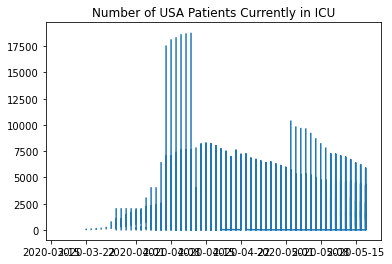

In [69]:
# Timeseries plot
plt.plot(all_cases.date, all_cases.hospitalizedCurrently)
plt.title('Number of USA Patients Currently in ICU')
# TODO change the X-axis to chip the year
# TODO which timeseries plots do we need?
# TODO how to temporarily remove the outliers?

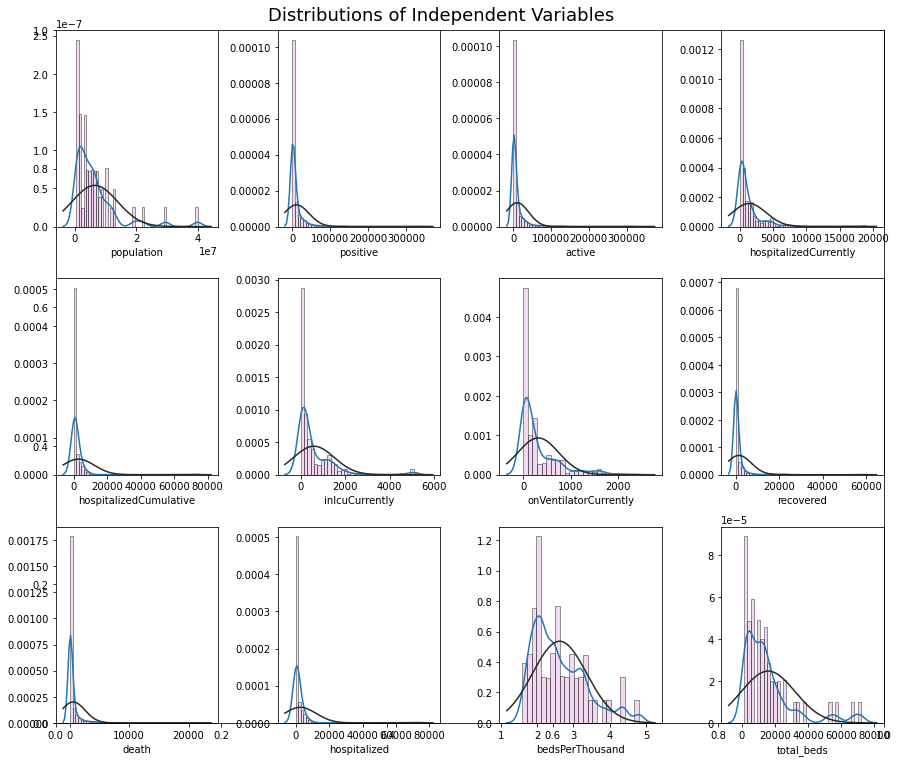

In [70]:
# Plotting histograms to gain insight of the distribution shape, skewness and scale
fig, ax = plt.subplots(figsize = (13, 11))
for i, col in enumerate(plot_df.columns):
    ax=fig.add_subplot(3, 4, i+1) 
    sns.distplot(plot_df[col], fit=norm, hist_kws=dict(color='plum', edgecolor="k", linewidth=1), ax=ax)
    #plt.legend() TODO add labels
    plt.suptitle('Distributions of Independent Variables', fontsize=18)
plt.tight_layout()
fig.subplots_adjust(top=0.95)

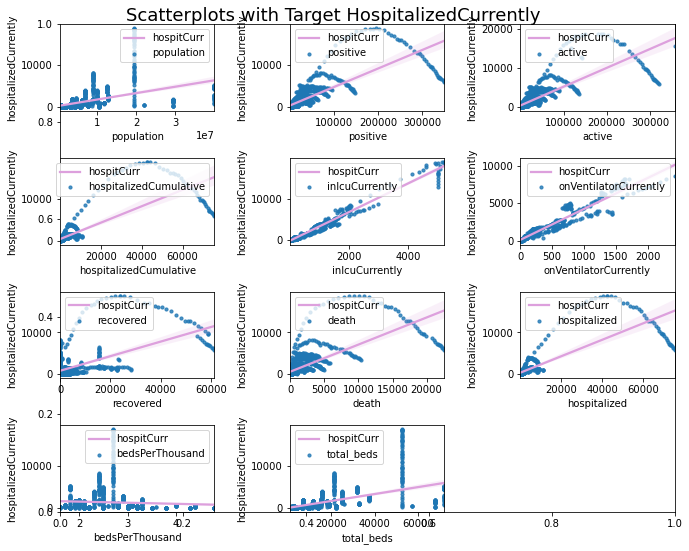

In [71]:
# Looking at linearity and variance with scatterplots
# Removing the target variable and saving it in another df
target = plot_df.hospitalizedCurrently
indep_var = plot_df.drop(columns=['hospitalizedCurrently'])

fig, ax = plt.subplots(figsize = (10, 8))
for i, col in enumerate(indep_var.columns):
    ax=fig.add_subplot(4, 3, i+1) 
    sns.regplot(x=indep_var[col], y=target, data=indep_var, label=col, scatter_kws={'s':10}, line_kws={"color": "plum", 'label': 'hospitCurr'})
    plt.suptitle('Scatterplots with Target HospitalizedCurrently', fontsize=18)
    plt.legend()
plt.tight_layout()
fig.subplots_adjust(top=0.95)

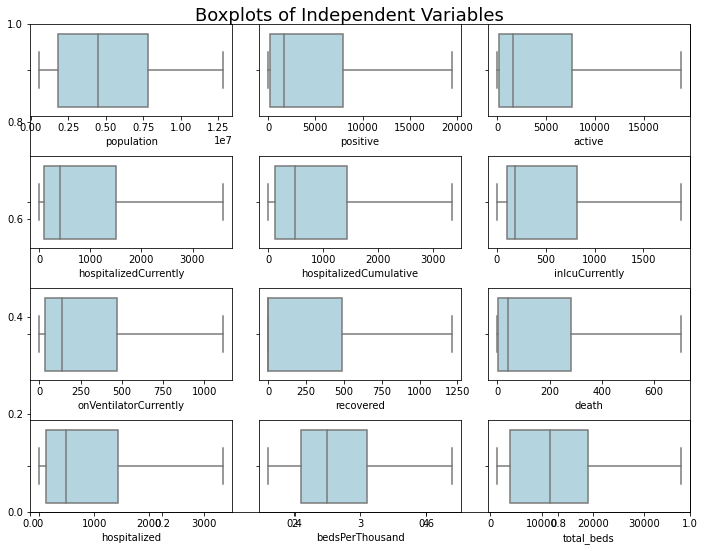

In [72]:
# Assessing the normality of the distribution with a boxplot
# Boxplot with removed outliers
fig, ax = plt.subplots(figsize = (10, 8))
for i, col in enumerate(plot_df.columns):
    ax=fig.add_subplot(4, 3, i+1) 
    sns.boxplot(x=plot_df[col], data=plot_df, color='lightblue', showfliers=False)
    plt.suptitle('Boxplots of Independent Variables', fontsize=18)
plt.tight_layout()
fig.subplots_adjust(top=0.95)

## New York and California Analysis
### Since the normality of the independent variables is highly questionable, we further assess the distribution by comparing two states (NY and CA) with eachother. 
We start with constructing scatter plots and boxplots of New York.

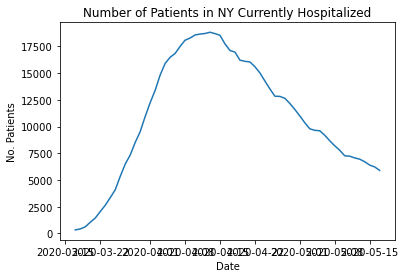

In [73]:
# Split all_cases into subset with only NY values
new_york = all_cases.loc[all_cases['abbrev'] == 'NY'] 

# Timeseries plt
plt.plot(new_york.date, new_york.hospitalizedCurrently)
plt.title('Number of Patients in NY Currently Hospitalized')
plt.xlabel('Date')
plt.ylabel('No. Patients')

# TODO the code below can be deleted once we fix the date format in plots
#set ticks every week
ax.xaxis.set_major_locator(mdates.WeekdayLocator())
#set major ticks format
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m'))

In [74]:
# Omit the categorical and date cols 
new_york = new_york[['positive', 'active', 'hospitalizedCurrently', 'hospitalizedCumulative', 'inIcuCurrently', 'recovered', 'death', 'hospitalized']]

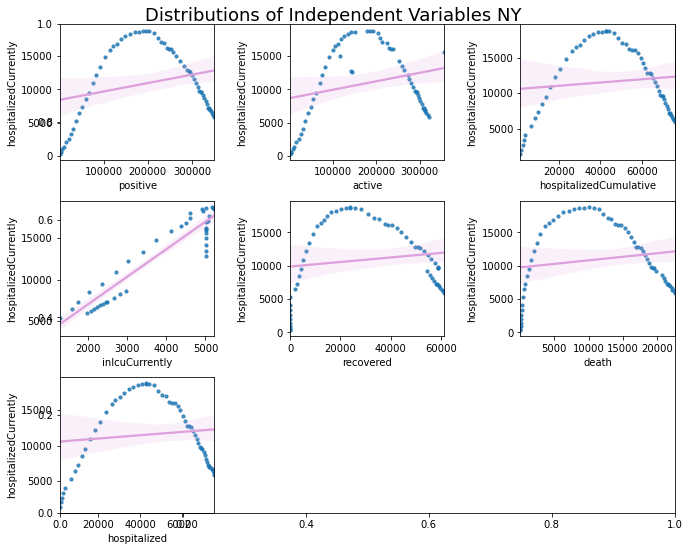

In [75]:
# Scatter plots NY
# Split dependent var from independent variables
target_ny = new_york.hospitalizedCurrently
indep_var_ny = new_york.drop(columns=['hospitalizedCurrently'])

fig, ax = plt.subplots(figsize = (10, 8))
for i, col in enumerate(indep_var_ny.columns):
    ax=fig.add_subplot(3, 3, i+1) 
    sns.regplot(x=indep_var_ny[col], y=target_ny, data=indep_var_ny, label=col, scatter_kws={'s':10}, line_kws={"color": "plum"})
    plt.suptitle('Distributions of Independent Variables NY', fontsize=18)
plt.tight_layout()
fig.subplots_adjust(top=0.95)


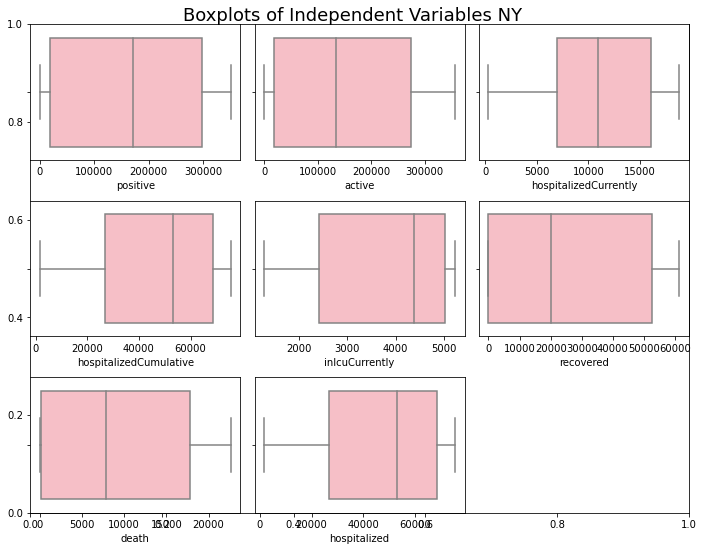

In [76]:
# Boxplot of NY
fig, ax = plt.subplots(figsize = (10, 8))
for i, col in enumerate(new_york.columns):
    ax=fig.add_subplot(3, 3, i+1) 
    sns.boxplot(x=new_york[col], data=new_york, color='lightpink', showfliers=True)
    plt.suptitle('Boxplots of Independent Variables NY', fontsize=18)
plt.tight_layout()
fig.subplots_adjust(top=0.95)

### Moving onto California:

In [77]:
cali = all_cases.loc[(all_cases['abbrev'] == 'CA') & (all_cases['state']== 'California')] 


Text(0, 0.5, 'No. Patients')

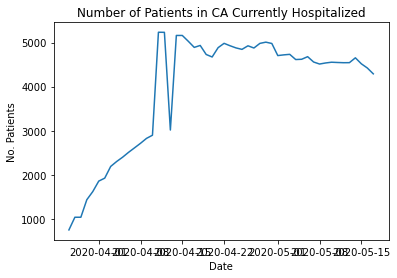

In [78]:
# TODO fix legend/axis/plot alltogether
# Timeseries plt
plt.plot(cali.date, cali.hospitalizedCurrently)
plt.title('Number of Patients in CA Currently Hospitalized')
plt.xlabel('Date')
plt.ylabel('No. Patients')

In [79]:
# Checking which cols have NaN values
cali[['positive', 'active', 'hospitalizedCurrently', 'inIcuCurrently', 'recovered', 'death', 'hospitalized']]
cali.head()

# Omit the NaN cols
cali = cali[['positive', 'active', 'hospitalizedCurrently', 'inIcuCurrently', 'recovered', 'death']]

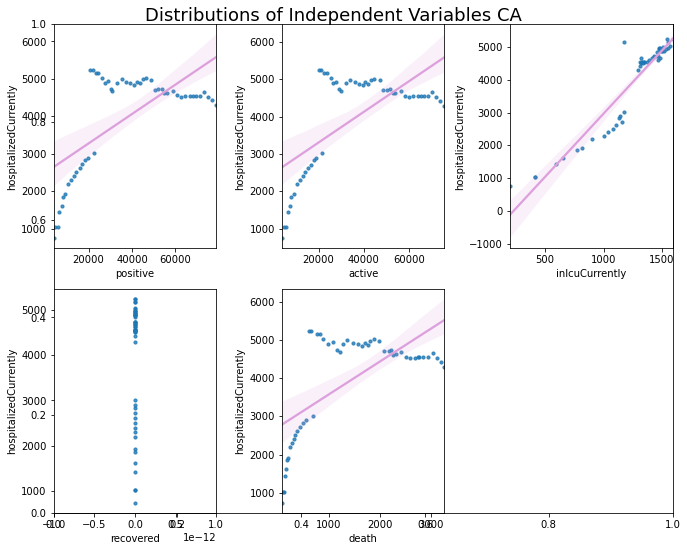

In [80]:
# Scatter plots CA
# Split dependent var from independent variables
target_ca = cali.hospitalizedCurrently
indep_var_ca = cali.drop(columns=['hospitalizedCurrently'])

fig, ax = plt.subplots(figsize = (10, 8))
for i, col in enumerate(indep_var_ca.columns):
    ax=fig.add_subplot(2, 3, i+1) 
    sns.regplot(x=indep_var_ca[col], y=target_ca, data=indep_var_ca, label=col, scatter_kws={'s':10}, line_kws={"color": "plum"})
    plt.suptitle('Distributions of Independent Variables CA', fontsize=18)
plt.tight_layout()
fig.subplots_adjust(top=0.95)

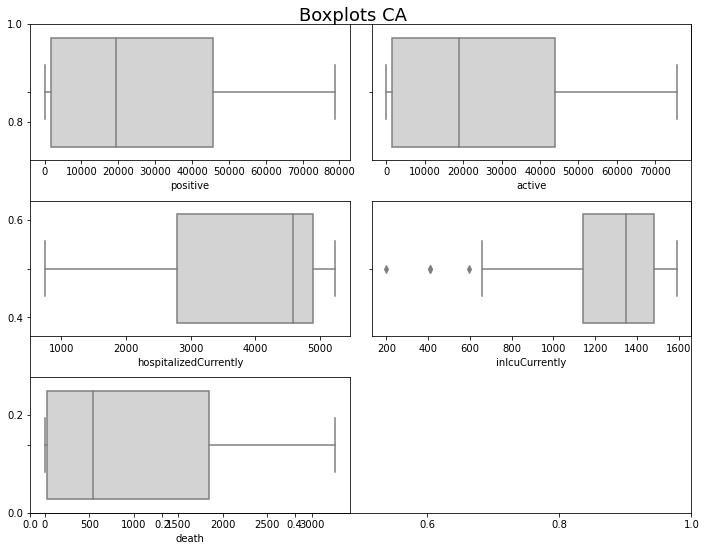

In [81]:
# Boxplot of CA
cali = cali[['positive', 'active', 'hospitalizedCurrently', 'inIcuCurrently', 'death']]
fig, ax = plt.subplots(figsize = (10, 8))
for i, col in enumerate(cali.columns):
    ax=fig.add_subplot(3, 2, i+1) 
    sns.boxplot(x=cali[col], data=cali, color='lightgrey', showfliers=True)
    plt.suptitle('Boxplots CA', fontsize=18)
plt.tight_layout()
fig.subplots_adjust(top=0.95)

## Assessing Correlation of Independent Variables

In [82]:
# TODO add some explanation / look more into collinear variables

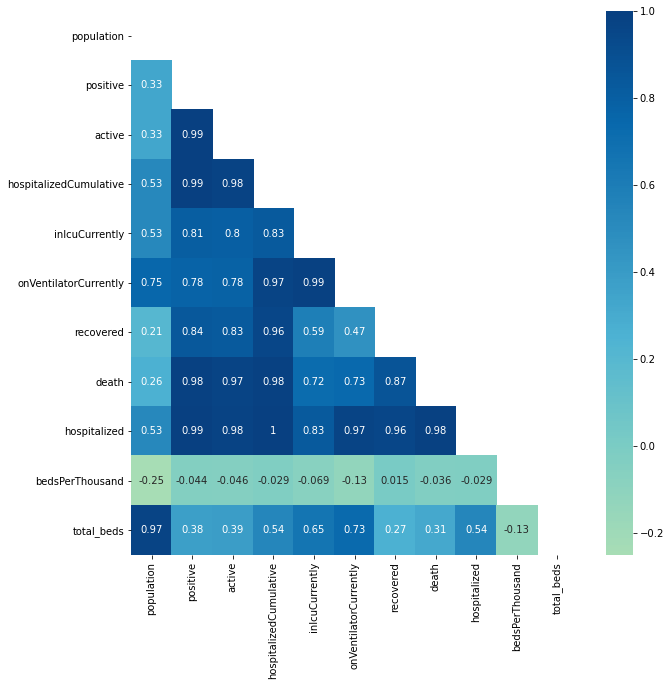

In [83]:
# Heatmap of correlations
# Save correlations to variable
corr = indep_var.corr()
# We can create a mask to not show duplicate values
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
# Generate heatmap
plt.figure(figsize= (10,10))
sns.heatmap(corr, annot=True, center=0, mask=mask, cmap='GnBu')
plt.show()

## Step 3: Build model for dependent Variable 
- To be used to predict hospitalizedCurrently
- Having more complete variables for inICUCurrently and onVentilatorCurrently will allow us to predict these numbers as well

In [84]:
# We compare three models:
# - Polynomial Regression
# - Linear Regression
# - ElasticNet

# Copy DFs to not mess up original one
# We will use model_df for our regression model
model_df = all_cases.copy()

# Delete redundant rows
for row in ['abbrev', 'bedsPerThousand', 'hospitalized', 
'state', 'hospitalizedCumulative', 'dataQualityGrade', 'lastUpdateEt']:
    del model_df[row]

# Drop NaN values for hospitalizedCurrently
model_df = model_df.dropna(subset=['hospitalizedCurrently'])

# Drop Values with abnormal active-hospitalised ratios (outside Conf. Interval)
model_df['ratio_hospital'] = model_df['hospitalizedCurrently'] / model_df['active']
model_df = model_df[~(model_df['ratio_hospital'] >= model_df.ratio_hospital.quantile(0.99))]

#model_df = model_df[~(model_df['ratio_hospital'] <= model_df['ratio_hospital'].median())]
del model_df['ratio_hospital']

# Get peek of model to use
model_df.describe()

population       positive         active  hospitalizedCurrently  \
count  1.721000e+03    1721.000000    1721.000000            1721.000000   
mean   7.056218e+06   21463.318420   19828.944218            1365.932016   
std    8.251494e+06   46534.598629   42315.797240            2560.569923   
min    5.670250e+05     115.000000     115.000000               3.000000   
25%    1.778070e+06    1670.000000    1574.000000             100.000000   
50%    4.499692e+06    6262.000000    5865.000000             402.000000   
75%    8.626207e+06   21504.000000   20132.000000            1511.000000   
max    3.993749e+07  350121.000000  356899.000000           18825.000000   

       inIcuCurrently  onVentilatorCurrently     recovered         death  \
count      861.000000             697.000000   1721.000000   1721.000000   
mean       604.839721             319.457676   2921.691458   1135.428239   
std        926.603637             438.773554   8128.432820   2833.940887   
min          2.000000               0.000000      0.000000      0.000000   
25%         96.000000              30.000000      0.000000     49.000000   
50%        179.000000             120.000000    391.000000    231.000000   
75%        850.000000             473.000000   1747.000000    901.000000   
max       5225.000000            2425.000000  61381.000000  22619.000000   

         total_beds  
count   1721.000000  
mean   16602.100648  
std    17457.639652  
min     1318.928100  
25%     3773.952000  
50%    11557.920400  
75%    19124.737000  
max    71887.480200

## One last thing:

Get all combinations of independent params

In [182]:
import itertools

# High train-test split = more data unknown to model
split = 0.2

independent_cols = [x for x in list(model_df.columns) if not(x in ['hospitalizedCurrently', 'inIcuCurrently', 'onVentilatorCurrently', 'date'])]

comb_list = []
len_ind = len(independent_cols)
for i in range(len_ind):
    sub_list = list(itertools.combinations(independent_cols, len_ind-i))
    comb_list += list(list(x) for x in sub_list)

### Model 1: Polynomial Regression

In [183]:
from sklearn.metrics import r2_score

mse_df1 = {'param_comb': [],
'degree': [],
'score': [],
'mean_abs_err': [],
'r_squared': []}

degrees = [2, 3]

for comb in comb_list:
    X = model_df[comb]
    y = model_df['hospitalizedCurrently']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=split)

    for d in degrees:

        polynomial_features = PolynomialFeatures(degree=d)
        x_poly_train = polynomial_features.fit_transform(X_train)

        x_poly_test = polynomial_features.fit_transform(X_test)

        model = LinearRegression()
        model.fit(x_poly_train, y_train)
        y_poly_pred = model.predict(x_poly_test)

        mse_df1['param_comb'].append(comb)
        mse_df1['score'].append(np.sqrt(mean_squared_error(y_test, y_poly_pred)))
        mse_df1['degree'].append(d)
        mse_df1['mean_abs_err'].append(mean_absolute_error(y_test, y_poly_pred))
        mse_df1['r_squared'].append(r2_score(y_test, y_poly_pred))

mse_df1 = pd.DataFrame(mse_df1)
mse_df1.sort_values(by='r_squared', ascending=False).head()

param_comb  degree       score  \
43             [active, recovered, death, total_beds]       3  465.684359   
41           [positive, recovered, death, total_beds]       3  459.787450   
11  [population, active, recovered, death, total_b...       3  415.583785   
9   [population, positive, recovered, death, total...       3  439.033088   
25          [population, positive, death, total_beds]       3  606.202257   

    mean_abs_err  r_squared  
43    270.312667   0.971893  
41    260.258036   0.971877  
11    262.077172   0.965515  
9     303.812238   0.964502  
25    366.567867   0.950391

The scores achieved by the polynomial model are suspiciously good. The errors are relatively low, and $R^2 \xrightarrow{} 1$. 

This indicates that we may be explaining the errors, rather than the data itself. This is a big warning sign that the polynomial model is overfitting.

### Model 2: Linear Regression

In [184]:
import itertools

mse_df = {'param_comb': [],
'score': [],
'mean_abs_err': [],
'r_squared': []}

for comb in comb_list:
    # Independent vars
    X = model_df[comb]

    # Dependent var
    y = model_df['hospitalizedCurrently']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=split)

    # Fit model
    linear_model = LinearRegression()
    linear_model.fit(X_train, y_train)

    y_pred = linear_model.predict(X_test)
    
    mse_df['param_comb'].append(comb)
    mse_df['score'].append(np.sqrt((mean_squared_error(y_test, y_pred))))
    mse_df['mean_abs_err'].append(mean_absolute_error(y_test, y_pred))
    mse_df['r_squared'].append(r2_score(y_test, y_pred))
mse_df = pd.DataFrame(mse_df)
mse_df.sort_values(by='r_squared', ascending=False).head()

param_comb        score  \
10          [population, positive, recovered, death]  1102.994499   
35                      [positive, recovered, death]  1238.431687   
1   [population, positive, active, recovered, death]  1021.686780   
33                         [positive, active, death]  1179.793696   
49                                 [positive, death]  1006.687921   

    mean_abs_err  r_squared  
10    551.027670   0.844538  
35    602.463196   0.843911  
1     541.156847   0.834186  
33    637.753033   0.828683  
49    583.628543   0.823117

This time, simple linear regression seems to work better. $R^2 \approx 0.87$ is a good score, indicative of high correlation between the dependent variable and all describing variables. 

It is possible to reduce the errors and maintain a good fit.

### Model 3: ElasticNet Regression

Cross-validate every combination (Look for best hyperparams first)

In [185]:
cross_val_results = {
    'columns': [],
    'alpha': [],
    'l1_ratio': []
}

for ind_cols in comb_list:
    X = model_df[ind_cols]
    y = model_df['hospitalizedCurrently']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=split)

    # Seek best params like we seek the COVID vaccine
    elastic = ElasticNet(normalize=True, max_iter=20000)
    search=GridSearchCV(estimator=elastic,param_grid={
        'alpha':np.logspace(-5, 2, 8),
        'l1_ratio':[.1, .2, .4, .6, .75, .8, .85, .9, .95, 1]},
        scoring='neg_mean_absolute_error',
        n_jobs=1,
        refit=True,
        cv=10)

    search.fit(X_train,y_train)
    cross_val_results['columns'].append(ind_cols)
    cross_val_results['alpha'].append(search.best_params_['alpha'])
    cross_val_results['l1_ratio'].append(search.best_params_['l1_ratio'])

cross_val_results = pd.DataFrame(cross_val_results)

In [193]:
score = []
mean_abs_err = []
r2_list = []

for i, row in cross_val_results.iterrows():
    alpha = cross_val_results.at[i, 'alpha']
    l1 = cross_val_results.at[i, 'l1_ratio']

    X = model_df[cross_val_results.at[i, 'columns']]
    y = model_df['hospitalizedCurrently']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=split)
    elastic = ElasticNet(normalize=True, alpha=alpha, l1_ratio=l1, max_iter=1000000)
    elastic.fit(X_train,y_train)

    rmse = (np.sqrt(mean_squared_error(y_true=y_test,y_pred=elastic.predict(X_test))))
    mae = mean_absolute_error(y_true=y_test, y_pred=elastic.predict(X_test))
    r2 = r2_score(y_test, elastic.predict(X_test))

    score.append(rmse)
    mean_abs_err.append(mae)
    r2_list.append(r2)

cross_val_results['score'] = score
cross_val_results['mean_abs_err'] = mean_abs_err
cross_val_results['r_squared'] = r2_list

cross_val_results.sort_values(by='r_squared', ascending=False).head()

columns    alpha  l1_ratio  \
49                                  [positive, death]  0.00001      0.85   
0   [population, positive, active, recovered, deat...  1.00000      1.00   
17               [positive, active, recovered, death]  0.10000      1.00   
20           [positive, recovered, death, total_beds]  0.00001      0.60   
37                      [positive, death, total_beds]  0.00001      0.60   

          score  mean_abs_err  r_squared  
49  1140.051711    600.278165   0.838901  
0   1129.894344    546.821318   0.831129  
17   993.986192    509.605446   0.826710  
20  1064.191784    547.820894   0.826375  
37   944.869648    511.176400   0.817776

In [187]:
#best MAE
best_r2 = 0
best_mae = 1000000000000
best_rmse = 100000000000
coeffs = []
intercept = 0
params = None

for i in range(0, 1000):
    X = model_df[['population', 'positive', 'active', 'recovered', 'death', 'total_beds']]
    y = model_df['hospitalizedCurrently']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=split)
    elastic = ElasticNet(normalize=True, alpha=0.00001, l1_ratio=0.6, max_iter=10000)
    elastic.fit(X_train, y_train)
    pred = elastic.predict(X_test)

    rmse = (np.sqrt(mean_squared_error(y_true=y_test,y_pred=pred)))
    mae = mean_absolute_error(y_true=y_test, y_pred=pred)
    r2 = r2_score(y_test, pred)

    if best_mae > mae:
        best_r2 = r2
        best_mae = mae
        best_rmse = rmse
        coeffs = elastic.coef_
        intercept = elastic.intercept_
        params = elastic.get_params


print(f"RMSE: {best_rmse}, MAE: {best_mae}, r2:{best_r2}")
print(f"Intercept: {intercept}\nCoefficients: {coeffs}\n\nParams:{params}")

RMSE: 796.1868782960304, MAE: 419.5828391724678, r2:0.7315984496919119
Intercept: -1.1300926763040025
Coefficients: [-5.47178164e-05  1.08528308e-01  1.99612585e-02 -7.33713250e-02
 -1.23923796e+00  4.07843153e-02]

Params:<bound method BaseEstimator.get_params of ElasticNet(alpha=1e-05, copy_X=True, fit_intercept=True, l1_ratio=0.6,
           max_iter=10000, normalize=True, positive=False, precompute=False,
           random_state=None, selection='cyclic', tol=0.0001, warm_start=False)>


In [188]:
# best r2
best_r2 = 0
best_mae = 1000000000000
best_rmse = 100000000000
coeffs = []
intercept = 0
params = None

for i in range(0, 1000):
    X = model_df[['population', 'positive', 'active', 'recovered', 'death', 'total_beds']]
    y = model_df['hospitalizedCurrently']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=split)
    elastic = ElasticNet(normalize=True, alpha=0.00001, l1_ratio=0.6, max_iter=10000)
    elastic.fit(X_train, y_train)
    pred = elastic.predict(X_test)

    rmse = (np.sqrt(mean_squared_error(y_true=y_test,y_pred=pred)))
    mae = mean_absolute_error(y_true=y_test, y_pred=pred)
    r2 = r2_score(y_test, pred)

    if r2 > best_r2:
        best_r2 = r2
        best_mae = mae
        best_rmse = rmse
        coeffs = elastic.coef_
        intercept = elastic.intercept_
        params = elastic.get_params


print(f"RMSE: {best_rmse}, MAE: {best_mae}, r2:{best_r2}")
print(f"Intercept: {intercept}\nCoefficients: {coeffs}\n\nParams:{params}")

RMSE: 777.9274494167739, MAE: 447.45634052316944, r2:0.8734349747943303
Intercept: -8.856279861256098
Coefficients: [-5.48585288e-05  1.03468919e-01  2.17727152e-02 -7.55234741e-02
 -1.21276922e+00  4.25796150e-02]

Params:<bound method BaseEstimator.get_params of ElasticNet(alpha=1e-05, copy_X=True, fit_intercept=True, l1_ratio=0.6,
           max_iter=10000, normalize=True, positive=False, precompute=False,
           random_state=None, selection='cyclic', tol=0.0001, warm_start=False)>


In the end, ElasticNet stroke the balance perfectly.

$R^2 \approx 0.87$ is similar to the linear regression model. 

We managed to reduce the errors, thanks to the ElasticNet's penalising measures which can help reduce the error but maintain a good fit.

Testing against unseen data further verifies ElasticNet's reliability.

## Step 4: Using findings from dataset of hospital beds, conclude research problem

In [189]:
# TODO specific correlation tests for hospitalisedCurrently vs. ICU & hospitalisedCurrently vs. Ventilator